## Jagt Log Bog og stat

First we start the logbook

In [2]:
import pandas as pd
from io import BytesIO
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

Then we define a couple of helper functions

In [3]:
def haglstr(x):
    try:
        f = np.float(x.replace(',', '.'))
        mm = round(f * 4) / 4
        if mm == 2.0:
            nr = '9'
        elif mm == 2.25:
            nr = '8'
        elif mm == 2.5:
            nr = '7'
        elif mm == 2.75:
            nr = '6'
        elif mm == 3.0:
            nr = '5'
        elif mm == 3.25:
            nr = '4'
        elif mm == 3.5:
            nr = '3'
        elif mm == 3.75:
            nr = '2'
        elif mm == 4.0:
            nr = '1'
    except:
        nr = 'Mix'
    return nr

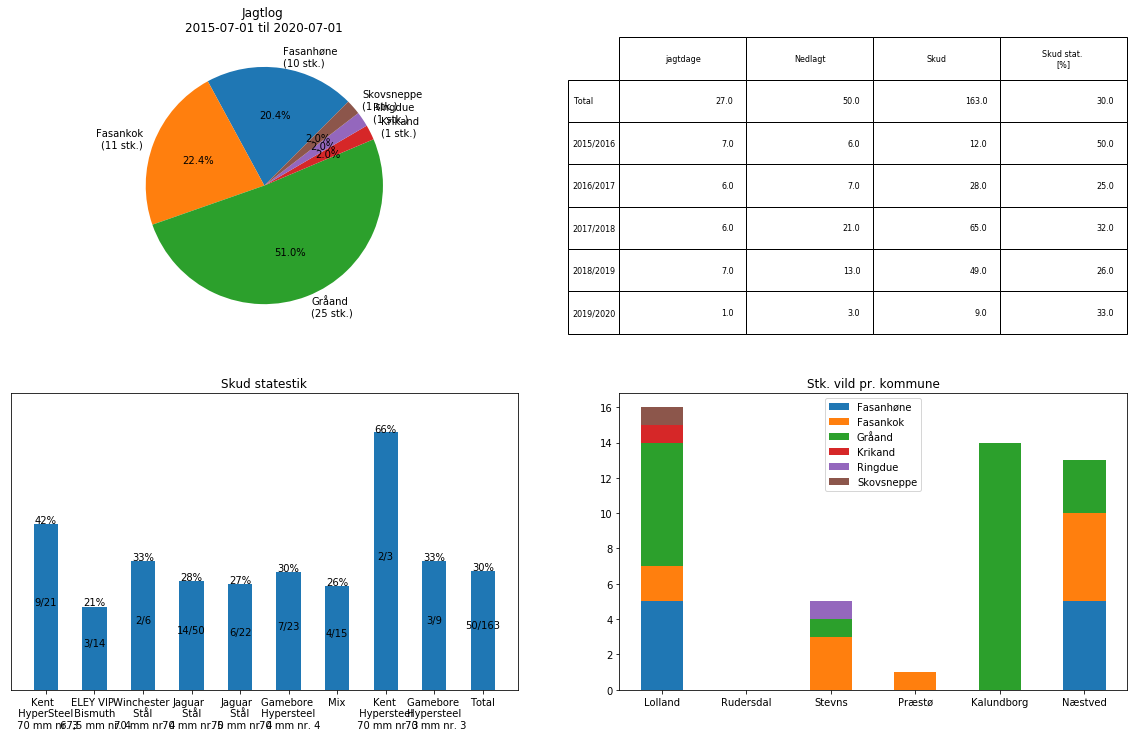

In [4]:
syr = 2015.
eyr = 2020.


r = requests.get('https://docs.google.com/spreadsheet/ccc?key=1O0aq_r43Y3twUZknICL0Czax_k_6H1osAXjRYualJyU&output=csv')
data = r.content
# df = pd.read_csv(StringIO(data), parse_dates=['Dato'], infer_datetime_format=True)
df = pd.read_csv(BytesIO(data), parse_dates=['Dato'], infer_datetime_format=True)
del df['Tidsstempel']
df.replace('nan', np.NaN)
df['Haglnr'] = df['Hagl størrelse (mm)'].apply(lambda col: haglstr(col))
df['Ammo'] = df['Ammunition fabrikant'] + ' \n ' + df['type'] + ' \n ' + df['Ammo Længde (mm)'] + ' mm nr. ' + df['Haglnr']
df['Ammo'] = df['Ammo'].replace(np.nan, 'Mix', regex=True)
df['nedlagt'] = df.fillna(0)['Antal Art 1'] + df.fillna(0)['Antal Art 2'] + df.fillna(0)['Antal Art 3'] + df.fillna(0)[
    'Antal Art 4']

stdag = datetime.datetime(int(syr), 7, 1)
endag = datetime.datetime(int(eyr), 7, 1)
subset = df[(df['Dato'] <= endag) & ((df['Dato'] >= stdag))]
### Plot dyr der er skydt...
art = [x for x in subset['Art 1'].unique() if str(x) != 'nan']

art = np.append(art, [x for x in subset['Art 2'].unique() if str(x) != 'nan'])
art = np.append(art, [x for x in subset['Art 3'].unique() if str(x) != 'nan'])
art = np.append(art, [x for x in subset['Art 4'].unique() if str(x) != 'nan'])
art = np.unique(art)
dyr = {}
sumdyr = 0.
for nn in art:
    for ii in range(1, 3):
        num = subset['Antal Art ' + str(ii)][subset['Art ' + str(ii)] == nn]
        if num.empty == False:
            if nn in dyr.keys():
                dyr[nn] = np.sum(num) + dyr[nn]
                sumdyr = sumdyr + dyr[nn]
            else:
                dyr[nn] = np.sum(num)
                sumdyr = sumdyr + dyr[nn]

# make a square figure and axes

fig = plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)

lab = []
for nn in dyr.keys():
    lab = np.append(lab, nn + '\n(' + str(int(dyr[nn])) + ' stk.)')
labels = lab
fracs = [(v / sumdyr) * 100. for k, v in dyr.items()]

plt.pie(fracs, labels=labels, autopct='%1.1f%%', startangle=45)
plt.title('Jagtlog \n' + str(stdag.date()) + ' til ' + str(endag.date()))

### faa skud stat for fabrik og storrelse

ammo = {}
ammosat = {}
N = 0.
S = 0.
for aa in subset['Ammo'].unique():
    n = subset['nedlagt'][subset['Ammo'] == aa].sum()
    N += n
    s = subset['Antal Skud'][subset['Ammo'] == aa].sum()
    S += s
    ammo[aa] = [n, s, np.round(n / s * 100., decimals=1)]
    ammosat[aa] = n / s * 100.

ammosat['Total'] = N / S * 100.
ammo['Total'] = [N, S, np.round(N / S * 100., decimals=1)]

ax = plt.subplot(2, 2, 3)
plt.title('Skud statestik')
X = np.arange(len(ammosat))
rects1 = plt.bar(X, ammosat.values(), align='center', width=0.5)
for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 0.99 * height,
            '%d' % int(height) + "%", ha='center', va='bottom')

aname = list(ammo.keys())
count = 0
for rect in rects1:
    ned = str(int(ammo[aname[count]][0]))
    sku = str(int(ammo[aname[count]][1]))
    height = rect.get_height()
    if height == 0.:
        ax.text(rect.get_x() + rect.get_width() / 2., 25.,
                ned + '/' + sku, ha='center', va='bottom')
    else:
        ax.text(rect.get_x() + rect.get_width() / 2., 0.5 * height,
                ned + '/' + sku, ha='center', va='bottom')
    count += 1

plt.xticks(X, ammosat.keys())
ymax = max(ammosat.values()) + 10
plt.ylim(0, ymax)
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)
frame1.axes.get_yaxis().set_ticks([])

## Kommune plot
kom = {}
dyr = []
flag = 0
dum = []
for nn in art:
    try:
        np.isnan(nn)
    except:
        dum = np.append(dum, 0.)

for kk in subset['Kommune'].unique():
    temp = np.zeros(len(dum))
    tmpdf = subset[subset['Kommune'] == kk]
    count = 0
    for nn in art:
        try:
            np.isnan(nn)
        except:
            if flag == 0:
                dyr = np.append(dyr, nn)
            for ii in range(1, 3):
                num = tmpdf['Antal Art ' + str(ii)][subset['Art ' + str(ii)] == nn]
                if num.empty == False:
                    temp[count] = np.sum(num) + temp[count]
            count += 1
    flag = 1
    kom[kk] = temp
komframe = pd.DataFrame(kom.values(), index=kom.keys(), columns=dyr)

ax = plt.subplot(2, 2, 4)
plt.title('Stk. vild pr. kommune')
bars = komframe.plot.bar(stacked=True, ax=ax, rot=0)

## over all jagt stat
plt.subplot(2, 2, 2)
## writing table of data
col_labels = ['jagtdage', 'Nedlagt', 'Skud', 'Skud stat. \n[%]']
row_labels = ['Total']
tmp = df['Dato'][len(df['Dato']) - 1]
if tmp.month >= 5:
    eyr = tmp.year + 1
else:
    eyr = tmp.year
for ii in range(df['Dato'][0].year, eyr):
    row_labels = np.append(row_labels, str(ii) + '/' + str(ii + 1))
table_vals = np.zeros((np.shape(row_labels)[0], np.shape(col_labels)[0]))
for ii in range(np.shape(row_labels)[0]):
    if ii == 0:
        season = df
    else:
        stdate = datetime.datetime(int(row_labels[ii][0:4]), 7, 1)
        endate = datetime.datetime(int(row_labels[ii][5:9]), 7, 1)
        season = df[(df['Dato'] <= endate) & ((df['Dato'] >= stdate))]
    table_vals[ii, 0] = len(season['Dato'].unique())
    table_vals[ii, 1] = int(season['nedlagt'].sum())
    table_vals[ii, 2] = int(season['Antal Skud'].sum())
    table_vals[ii, 3] = int(float(table_vals[ii, 1]) / float(table_vals[ii, 2]) * 100.)

# the rectangle is where I want to place the table
the_table = plt.table(cellText=table_vals,
                      # colWidths = [0.27]*3,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center',
                      bbox=[0, 0, 1, 1])
the_table.set_fontsize(8)
the_table.scale(1, 2)
ax = plt.gca()
for side in ['bottom', 'right', 'top', 'left']:
    ax.spines[side].set_visible(False)
plt.xticks([])  # labels
plt.yticks([])
ax.xaxis.set_ticks_position('none')  # tick markers
ax.yaxis.set_ticks_position('none')
plt.show(block=True)